# Alpha-Beta (CAPM) Demo with NVDA, S\&P 500, and Gold
This notebook:
1. loads prices for S\&P 500 ( SPX ), NVIDIA ( NVDA ), and Gold
2. cleans \& aligns calendars
3. computes daily returns
4. explores relationships with scatter plots
5. estimates alpha (intercept) and beta (slope) for NVDA vs S\&P 500 using linear regression
6. interprets the results and comments on Gold vs equities

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True
pd.options.display.float_format = '{:,.6f}'.format


# 1) Load and clean the data

We expect three CSV files:
- SPX.csv with a Date column and an adjusted close column named like Adj Close or similar
- NVDA.csv with a Date column and a Close/Last column containing dollar strings (e.g., "\$174.18")
- gold_prices.csv (semicolon ; separated) with Date and Close


In [71]:
# --- S&P 500 ---
SPX = pd.read_csv("SPX.csv", index_col="Date")
SPX.index = pd.to_datetime(SPX.index)
# Keep one close column and rename to SPX
# If your file has a different name, change 'Adj Close' accordingly
SPX = SPX[['Adj Close']].rename(columns={'Adj Close': 'SPX'}).sort_index()

# --- NVDA ---
# NVDA file has dollar strings; convert them to floats
def parse_dollar(x):
    if pd.isna(x):
        return np.nan
    return float(str(x).replace('$','').replace(',',''))

NVDA = pd.read_csv(
    "NVDIA.csv", index_col="Date",
    converters={'Close/Last': parse_dollar}
)
NVDA.index = pd.to_datetime(NVDA.index)
NVDA = NVDA[['Close/Last']].rename(columns={'Close/Last': 'NVDA'}).sort_index()

# --- Gold ---
gold = pd.read_csv("gold_prices.csv", delimiter=";", index_col=0)
gold.index = pd.to_datetime(gold.index)
gold = gold[['Close']].rename(columns={'Close': 'Gold'}).sort_index()

SPX.head(), NVDA.head(), gold.head()


(                 SPX
 Date                
 1927-12-30 17.660000
 1928-01-03 17.760000
 1928-01-04 17.719999
 1928-01-05 17.549999
 1928-01-06 17.660000,
                NVDA
 Date               
 2015-08-31 0.562000
 2015-09-01 0.539000
 2015-09-02 0.555300
 2015-09-03 0.556700
 2015-09-04 0.543800,
                  Gold
 Date                 
 2004-06-11 384.100000
 2004-06-14 382.800000
 2004-06-15 388.600000
 2004-06-16 383.800000
 2004-06-17 387.600000)

# 2) Align calendars (inner join) and inspect

Different markets/feeds have different trading holidays. 
We inner join on dates to keep only overlapping trading days across series.

In [73]:
# Join step by step to make it explicit
both = SPX.join(gold, how="inner")
df = both.join(NVDA, how="inner")

df = df.sort_index()
df.info()
df.tail()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2015-08-31 to 2020-11-04
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPX     1306 non-null   float64
 1   Gold    1306 non-null   float64
 2   NVDA    1306 non-null   float64
dtypes: float64(3)
memory usage: 40.8 KB


,SPX,Gold,NVDA
Date,,,
2020-10-29,"3,310.110107","1,867.110000",13.024000
2020-10-30,"3,269.959961","1,878.370000",12.534000
2020-11-02,"3,310.239990","1,895.060000",12.580800
2020-11-03,"3,369.159912","1,908.940000",13.019500
2020-11-04,"3,443.439941","1,903.270000",13.794300


# 3) Compute daily returns

We’ll use simple returns (percent change). If you prefer log returns, replace pct_change() with np.log(price).diff().


In [74]:
rets = pd.DataFrame(index=df.index)
rets['SPX_return']   = df['SPX'].pct_change()
rets['NVDA_return']  = df['NVDA'].pct_change()
rets['Gold_return']  = df['Gold'].pct_change()

# Drop the first row (NaN from differencing) and any other missing values
rets = rets.dropna()
rets.head()


,SPX_return,NVDA_return,Gold_return
Date,,,
2015-09-01,-0.029576,-0.040925,0.004636
2015-09-02,0.018293,0.030241,-0.005430
2015-09-03,0.001165,0.002521,-0.007647
2015-09-04,-0.015330,-0.023172,-0.002471
2015-09-08,0.025083,0.042663,-0.000944


# 4) Quick context: price levels and first glance at returns

,SPX,Gold,NVDA,SPX_return,NVDA_return,Gold_return
Date,,,,,,
2020-10-29,"3,310.110107","1,867.110000",13.024000,0.011947,0.031441,-0.005168
2020-10-30,"3,269.959961","1,878.370000",12.534000,-0.012130,-0.037623,0.006031
2020-11-02,"3,310.239990","1,895.060000",12.580800,0.012318,0.003734,0.008885
2020-11-03,"3,369.159912","1,908.940000",13.019500,0.017799,0.034871,0.007324
2020-11-04,"3,443.439941","1,903.270000",13.794300,0.022047,0.059511,-0.002970


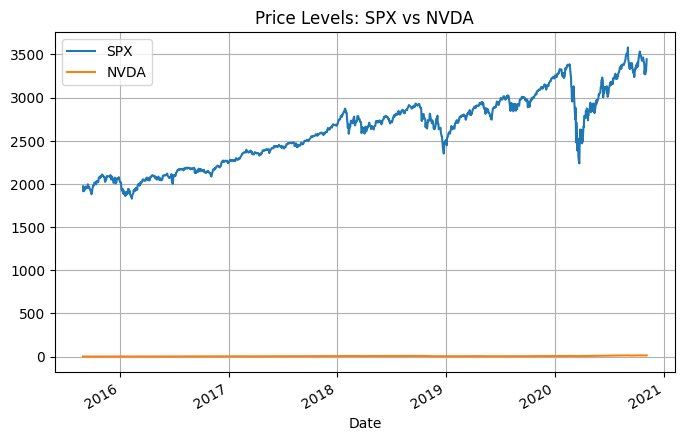

In [75]:
# Price levels (SPX and NVDA): useful for intuition
df[['SPX', 'NVDA']].plot(title='Price Levels: SPX vs NVDA');

# Simple sanity table: prices + returns aligned (last few rows)
pd.concat([df[['SPX','Gold','NVDA']], rets], axis=1).tail()


# 5) Gold vs S&P 500 — scatter and correlation

The common story is that Gold may diversify equity risk. Let’s visualize Gold_return vs SPX_return and compute correlation.


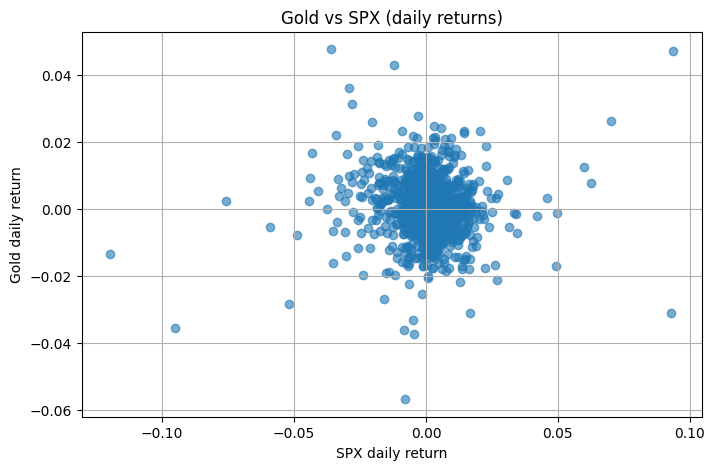

Gold vs SPX daily correlation: -0.022


In [76]:

ax = plt.subplot()
plt.scatter(rets['SPX_return'], rets['Gold_return'], alpha=0.6)
plt.xlabel('SPX daily return')
plt.ylabel('Gold daily return')
plt.title('Gold vs SPX (daily returns)')
plt.show()

corr_gold_spx = rets['Gold_return'].corr(rets['SPX_return'])
print(f"Gold vs SPX daily correlation: {corr_gold_spx:.3f}")


Interpretation:
Daily correlations often hover near zero or small negatives. A low/negative correlation supports the idea that gold can diversify equity risk; it does not mean gold always rises when stocks fall—especially at daily frequency.

# 6) NVDA vs S&P 500 — scatter and intuition


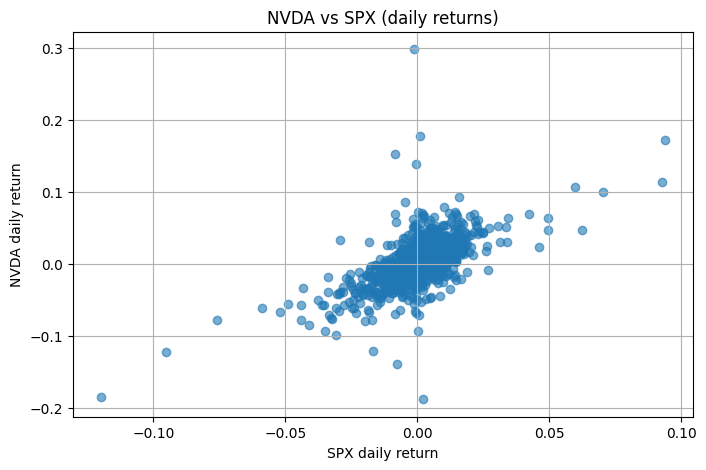

NVDA vs SPX daily correlation: 0.619


In [78]:
plt.scatter(rets['SPX_return'], rets['NVDA_return'], alpha=0.6)
plt.xlabel('SPX daily return')
plt.ylabel('NVDA daily return')
plt.title('NVDA vs SPX (daily returns)')
plt.show()

corr_nvda_spx = rets['NVDA_return'].corr(rets['SPX_return'])
print(f"NVDA vs SPX daily correlation: {corr_nvda_spx:.3f}")

# 7) Alpha-Beta estimation (CAPM-style regression)

We regress NVDA's return on the SPX return (1-factor CAPM without a risk-free leg). The intercept is alpha (average excess beyond market), the slope is beta (market sensitivity).

Two ways are shown:
1. scikit-learn for a quick slope/intercept + prediction line
2. statsmodels for a full regression summary (t-stats, $R^2$, etc.)

If you don't have statsmodels, you can skip that cell.

scikit-learn -> alpha (intercept): 0.002133, beta (slope): 1.515


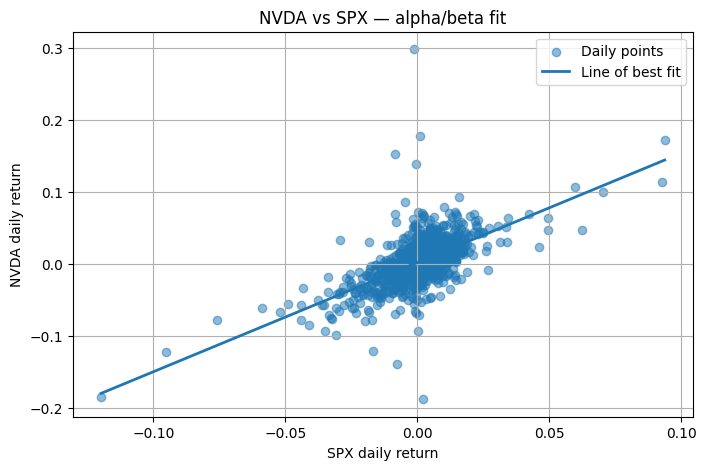

In [79]:
# ---------- (A) scikit-learn ----------
from sklearn.linear_model import LinearRegression

X = rets[['SPX_return']].to_numpy()
Y = rets['NVDA_return'].to_numpy()

model = LinearRegression()
model.fit(X, Y)

alpha_skl = float(model.intercept_)
beta_skl  = float(model.coef_[0])

print(f"scikit-learn -> alpha (intercept): {alpha_skl:.6f}, beta (slope): {beta_skl:.3f}")

# Draw the regression line on top of the scatter
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_line = model.predict(x_line)

plt.scatter(rets['SPX_return'], rets['NVDA_return'], alpha=0.5, label='Daily points')
plt.plot(x_line, y_line, color='tab:blue', lw=2, label='Line of best fit')
plt.xlabel('SPX daily return')
plt.ylabel('NVDA daily return')
plt.title('NVDA vs SPX — alpha/beta fit')
plt.legend()
plt.show()


In [80]:
# ---------- (B) statsmodels (optional, richer output) ----------
import statsmodels.api as sm

Xc = sm.add_constant(rets['SPX_return'])  # adds intercept term
ols = sm.OLS(rets['NVDA_return'], Xc).fit()
print(ols.summary())

alpha_sm = ols.params['const']
beta_sm  = ols.params['SPX_return']
r2_sm    = ols.rsquared
print(f"\nstatsmodels -> alpha: {alpha_sm:.6f}, beta: {beta_sm:.3f}, R^2: {r2_sm:.3f}")


                            OLS Regression Results                            
Dep. Variable:            NVDA_return   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     810.0
Date:                Sat, 30 Aug 2025   Prob (F-statistic):          5.92e-139
Time:                        23:16:35   Log-Likelihood:                 3053.1
No. Observations:                1305   AIC:                            -6102.
Df Residuals:                    1303   BIC:                            -6092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.300      0.0